# Performance and Timing

This is the scikit-learn half of a comparison to TMVA's operation.

 - We use 10 trees to train
 - 100K events (presumably)
 - [Event Dumper Job](http://higgs.phys.washington.edu:8080/job/CalRatio2016/job/MVADumpTrainingTuples/18/).
 - [Training Job](http://higgs.phys.washington.edu:8080/job/CalRatio2016/job/JetMVAClassifierTraining/191/).
 

## Initalization

In [1]:
from bdt_training_scikit_tools import plot_training_performance, load_default_samples, test_train_samples, prep_samples, default_training, calc_performance, calc_performance_for_run

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os
from math import sqrt

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

## Load data

In [2]:
all_events = load_default_samples("20")

# WARNING: we are taking out x-section weights because the TMVA training we use for comparison below (job 194) doesn't have
# the x-section weights in due to an oversight.
for i in (0,1,2):
    all_events[i].loc[:,'WeightXSection'] = pd.Series(np.ones(len(all_events[i].index)), index=all_events[i].index)

training, testing = test_train_samples(all_events)

BIB: 100000 events
Multijet: 100000 events
Signal: 100000 events


## Run Training
Run the default training with these events

In [3]:
training_events, training_class, training_weight, training_eval_weight = prep_samples(training[0], training[1], training[2])
testing_events, testing_class, testing_weight, testing_eval_weight = prep_samples(testing[0], testing[1], testing[2])

In [4]:
%%time
bdt = default_training(training_events, training_weight, training_class, min_leaf_fraction=0.001)

Wall time: 1min 23s


## Performance Training Performance
Check to make sure the training worked well - there isn't an issue with over training, that the number of trees used were enough, etc.

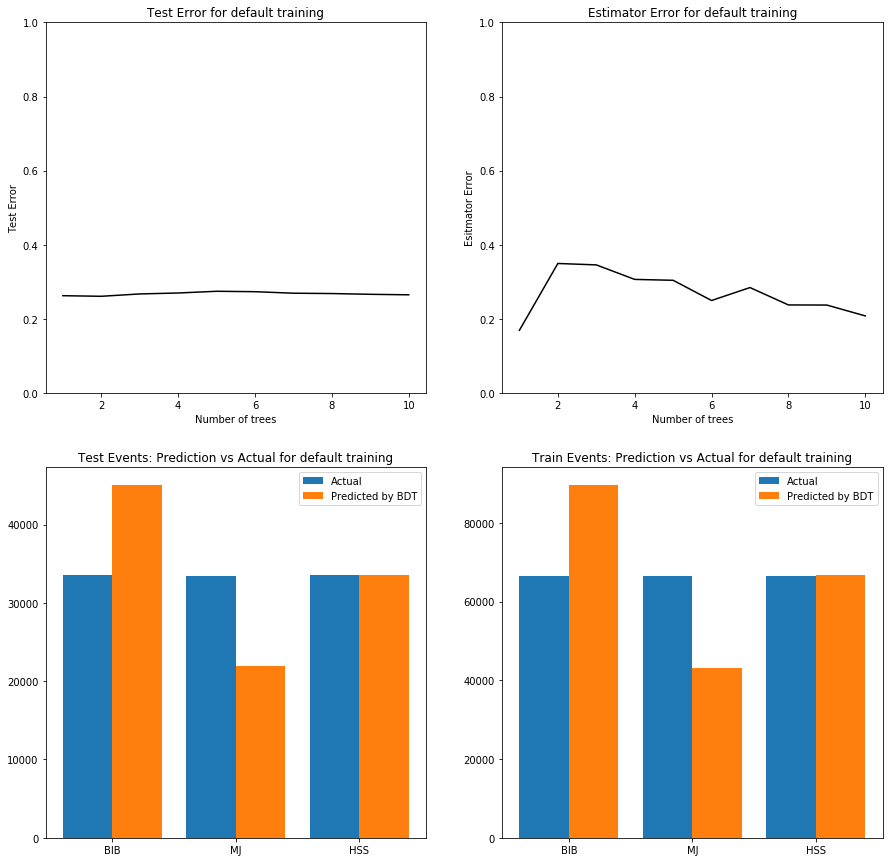

In [5]:
plot_training_performance(bdt, training, testing, "default")

## Seperation Performance
Look at how good this training is

In [6]:
d_scikit_learn = calc_performance(bdt, testing)
pd.DataFrame({'SciKitLearn':d_scikit_learn})

,SciKitLearn
BIBBack,404975.240530
BIBEff,0.791966
BIBSsqrtB,41.701719
BIBTotalCount,33509.000000
BIBTotalWeight,33509.000000
BIBinBIB,26538.000000
BIBinHSS,1189.000000
BIBinMJ,5782.000000
HSSBack,13981.232160
HSSEff,0.944145


# Performance Data from TMVA
Look at the data that has come back from a similar TMVA run.

# Loading Data

In [7]:
# Some defaults
data_location = "..\\..\\MCAResultsData"
jenkins_build = "194"
signal_sample_names=["125pi25lt5m", "200pi25lt5m", "400pi50lt5m", "600pi150lt5m", "1000pi400lt5m", "training_hss"]
bib_sample_names=["data16"]
mj_sample_names=["jz", "training_mj"]

def load_mva_data(sample_name):
    """Load the data written out by a MVA training job into an np array.
    Returns null if the csv file can't be found.
    
    Args:
      sample_name: The name of the sample, e.g. data15
    """
    p = "{0}\\{1}\\all-{2}.csv".format(data_location, jenkins_build, sample_name)
    if not os.path.exists(p):
        return None
    return pd.read_csv(p)

def load_mva_data_from_list(lst):
    """Load data for a series of samples. Silently ignore those we can't find
    
    Args:
        lst: List of samples to load
    """
    return {s[0] : s[1] for s in [(sname, load_mva_data(sname)) for sname in lst] if not(s[1] is None)}

In [8]:
signal_samples = load_mva_data_from_list(signal_sample_names)
bib_samples = load_mva_data_from_list(bib_sample_names)
mj_samples = load_mva_data_from_list(mj_sample_names)

## Determine the Performance
The TMVA multi-class isn't the same as the scikit-learn. TMVA gives us a probability. In some sense, what TMVA gies us is better than what scikit-learn gives us. None-the-less, to do the comparison we need to convert TMVA's output to something that looks like scikit-learn. We'll just take the largest value of the three weights, and that will determine the output type.

In [9]:
def convert_sample (sample):
    '''Convert from the TMVA values to scikit-learn values
    
    Args
        sample - the same DataFrame (with all the weights)
        
    Return
        df - A dataframe with an event weight column (Weight) and a class column (0, 1, 2 for bib, mj, and signal)
    '''
    itis_signal = (sample.HSSWeight > sample.MultijetWeight) & (sample.HSSWeight > sample.BIBWeight)
    itis_bib = (sample.BIBWeight > sample.MultijetWeight) & (sample.BIBWeight > sample.HSSWeight)
    itis_mj = (sample.MultijetWeight > sample.HSSWeight) & (sample.MultijetWeight > sample.BIBWeight)
    s_class = itis_mj*1 + itis_signal*2
    return pd.DataFrame({'Weight':sample.WeightMCEvent*sample.WeightXSection, 'PredClass':s_class})

def take_testing(s):
    '''Take only the events to use for testing
    
    Arss
        s - The DataFrame with EventNumber in it.
    '''
    return s[s.EventNumber % 3 == 0]

signal_samples_skl = {k:convert_sample(take_testing(signal_samples[k])) for k in signal_samples}
bib_samples_skl = {k:convert_sample(take_testing(bib_samples[k])) for k in bib_samples}
mj_samples_skl = {k:convert_sample(take_testing(mj_samples[k])) for k in mj_samples}

For the scikit-learn we had the signal all put together and the bib16 and the mj. So combine the signal here.

In [10]:
bib = pd.DataFrame(bib_samples_skl["data16"])
bib.loc[:,'Class'] = pd.Series(np.zeros(len(bib.index)), index=bib.index, dtype=int)
mj = pd.DataFrame(mj_samples_skl["training_mj"])
mj.loc[:,'Class'] = pd.Series(np.ones(len(mj.index)), index=mj.index, dtype=int)
signal = pd.DataFrame(signal_samples_skl["training_hss"])
signal.loc[:,'Class']=pd.Series(np.ones(len(signal.index))*2, index=signal.index, dtype=int)

tmva_results = bib.append(mj).append(signal)

In [11]:
d_tmva = calc_performance_for_run(tmva_results)

In [12]:
df_compare = pd.DataFrame({'TMVA': d_tmva, 'SciKitLearn':d_scikit_learn})
df_compare

,SciKitLearn,TMVA
BIBBack,404975.240530,133914.239380
BIBEff,0.791966,0.522202
BIBSsqrtB,41.701719,47.756078
BIBTotalCount,33509.000000,33466.000000
BIBTotalWeight,33509.000000,33466.000000
BIBinBIB,26538.000000,17476.000000
BIBinHSS,1189.000000,1807.000000
BIBinMJ,5782.000000,14183.000000
HSSBack,13981.232160,22419.775430
HSSEff,0.944145,0.982246
